In [1]:
import numpy as np
import pandas as pd
import scipy.stats
%matplotlib inline

### This project consists of 4 parts. 
1- Understand the dataset and check if the returns are normally distributed or not <br>
2- Analyze 4 industries; Calculate drawdowns for the returns of the Oil industry<br>
3- Calculate the Value at Risk (VaR) for all industries<br>
4- Portfolio Optimization

In [35]:
ind_returns = pd.read_csv("C:/Users/aleem/Documents/Quant finance/Excel files - online learning/Practice Datasets/17_Industry_Portfolios.csv", 
                     header = 0, index_col = 0, parse_dates = True)
ind_returns.columns = ind_returns.columns.str.strip()
ind_returns.index = pd.to_datetime(ind_returns.index, format = '%Y%m').to_period('M')
ind_returns = ind_returns/100
ind_returns.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
1926-07,0.0048,0.0378,-0.0141,0.0602,-0.0162,0.0846,0.0142,0.0231,0.0407,0.0877,0.0379,0.1743,0.0184,0.0704,0.0013,0.0037,0.0122
1926-08,0.0291,0.0069,0.0360,0.0015,-0.0196,0.0570,0.0584,0.0433,0.0217,-0.0556,0.0235,0.0396,0.0457,-0.0169,-0.0068,0.0446,0.0311
1926-09,0.0120,0.0110,-0.0368,0.0026,0.0024,0.0548,0.0121,-0.0006,0.0015,-0.0413,-0.0065,0.0557,0.0030,0.0204,0.0021,-0.0123,0.0182
1926-10,-0.0306,-0.0079,-0.0102,0.0037,-0.0607,-0.0476,0.0069,-0.0479,-0.0385,-0.0513,-0.0329,-0.0829,-0.0292,-0.0263,-0.0226,-0.0516,-0.0088
1926-11,0.0637,0.0438,-0.0001,0.0222,-0.0195,0.0527,0.0463,0.0245,0.0386,0.0357,0.0454,-0.0028,0.0218,0.0371,0.0644,0.0224,0.0138


### 1- Check if returns are normally distributed or not, using the Jarque-Bera test. Start off with the null hypothesis that returns are normally distributed

In [146]:
list = ["Food", "Oil", "Cars", "Finan"]
def is_normal(returns):
    statistic, p_value = scipy.stats.jarque_bera(returns)
    return p_value > 0.05

ind_returns[list].aggregate(is_normal)

Food     False
Oil      False
Cars     False
Finan    False
dtype: bool

### 2- Calculate maximum drawdowns for the Oil industry with an initial investment of 1000 in 1995

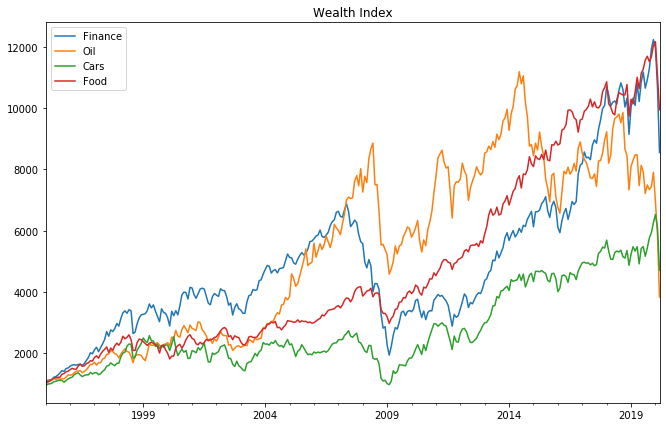

In [132]:
def drawdown(returns: pd.Series):
    wealth_index = 1000 * (1+returns).cumprod()
    peaks = wealth_index.cummax()
    drawdowns = (wealth_index - peaks)/peaks
    return pd.DataFrame({"Wealth": wealth_index,
                        "Peaks": peaks,
                        "Drawdowns": drawdowns})

drawdown(ind_returns['Finan']["1995":])["Wealth"].plot(figsize = (11,7), title = "Wealth Index", legend = True, label = "Finance")
drawdown(ind_returns['Oil']["1995":])["Wealth"].plot(figsize = (11,7), legend = True, label = "Oil")
drawdown(ind_returns['Cars']["1995":])["Wealth"].plot(figsize = (11,7), legend = True, label = "Cars")
drawdown(ind_returns['Food']["1995":])["Wealth"].plot(figsize = (11,7), legend = True, label = "Food")

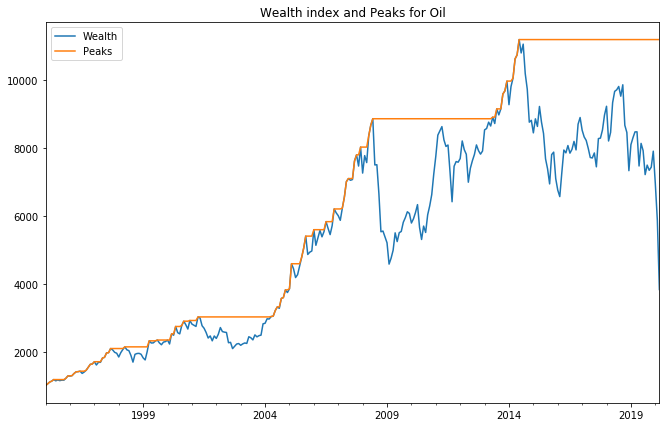

In [138]:
# The Food and Cars industries have generally been stable compared to the Oil and Finance industries. We saw a massive 
# dip in the Finance industry during the 2008 crash, however, Oil has been more volatile when we look at this graph so 
# lets find the drawdown for it.
drawdown(ind_returns['Oil']["1995":])[["Wealth", "Peaks"]].plot(figsize = (11,7), title = "Wealth index and Peaks for Oil")

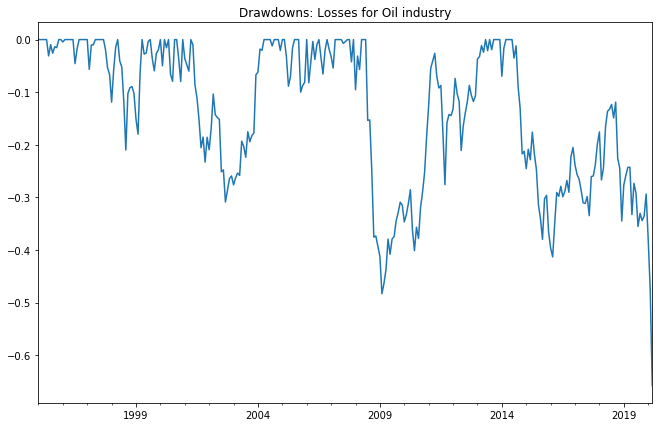

In [139]:
drawdown(ind_returns['Oil']["1995":])["Drawdowns"].plot(figsize = (11,7), title = "Drawdowns: Losses for Oil industry")

### 3- Calculate VaR using the Cornish-Fisher method. Returns are non-Normal so a VaR procedure is ideal to calculate risk of the industries.

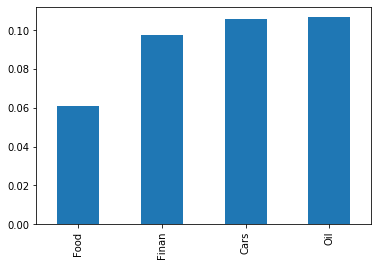

In [147]:
from scipy.stats import norm

def var_cf(returns):
    z = norm.ppf(0.05)
    s = scipy.stats.skew(returns)
    k = scipy.stats.kurtosis(returns)
    z = (z +
        (z**2 - 1)*s/6 + 
        (z**3 - 3*z)*(k-3)/24 -
        (2*z**3 - 5*z)*(s**2)/36)
    return -(returns.mean() + z * returns.std())

var_cf(ind_returns["1995":][["Food", "Oil", "Cars", "Finan"]]).sort_values().plot.bar()          

### 4- Portfolio Optimization: calculate Sharpe Ratios and allocate weights between 4 different industries

In [75]:
def annualized_returns(returns):
    compound_return = (1+returns).prod()
    n_periods = returns.shape[0]
    return compound_return**(12/n_periods)

def annualized_vol(returns):
    return returns.std() * 12**0.5

def sharpe_ratio(returns, riskfree_rate):
    rf_per_period = (1 + riskfree_rate)**(1/12)
    excess_return = returns - riskfree_rate
    ann_ret = annualized_returns(excess_return)
    ann_vol = annualized_vol(returns)
    return ann_ret/ann_vol

In [88]:
industries = ["Food", "Oil", "Cars", "Finan"]
exp_ret = annualized_returns(ind_returns["1995":])
exp_vol = annualized_vol(ind_returns["1995":])
covmat = ind_returns["1995":].cov()
sr = sharpe_ratio(ind_returns["1995":], 0.01)
data_summary = pd.concat([exp_ret[industries], exp_vol[industries], sr[industries]], axis = 'columns')
data_summary.columns = ["Exp_Ret", "Exp_Vol", "SRatio"]
data_summary

,Exp_Ret,Exp_Vol,SRatio
Food,1.095242,0.132162,7.351655
Oil,1.054612,0.214544,4.358352
Cars,1.063226,0.231198,4.077645
Finan,1.088716,0.197082,4.899718


### Quadratic program for optimization
### $min \sum_{i=1}^{n}.\sum_{j=1}^{n}.w_i.w_j. \sigma_{ij}$

$\sum_{i=1}^{n}.w_i = 1$

$\sum_{i=1}^{n}.r_i.\bar{w_i} = z$

$w_i \geqslant 0\ for\ all\ i=1,2,....n$

In [91]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

# lets set up the optimizer now
from scipy.optimize import minimize

def minimize_vol(target_return, exp_ret, covmat):
    n = len(industries)
    initial_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n
    return_constraint = {
        'type': 'eq',
        'args': (exp_ret,),
        'fun': lambda weights, exp_ret: target_return - portfolio_return(weights, exp_ret)
    }
    weights_constraint = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(portfolio_vol, 
                       initial_guess,
                      args = (covmat,),
                      method = 'SLSQP',
                      options = {'disp': False},
                      constraints = (return_constraint, weights_constraint),
                      bounds = bounds)
    return results.x

In [145]:
# lets say we set a target return of 15% per year. How much should we allocate to each of the 4 assets?
minimize_vol(0.15, exp_ret[industries], covmat.loc[industries, industries])

array([2.69234524e-13, 1.00000000e+00, 2.86662582e-12, 5.95127384e-13])

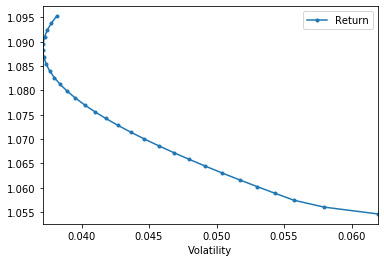

In [112]:
# plot the efficient frontier
def optimal_weights(num_points, exp_ret, covmat):
    target_returns = np.linspace(exp_ret.min(), exp_ret.max(), num_points)
    weights = [minimize_vol(target_return, exp_ret, covmat) for target_return in target_returns]
    return weights

def plot_ef(num_points, exp_ret, covmat):
    weights = optimal_weights(num_points, exp_ret, covmat)
    rets = [portfolio_return(w, exp_ret) for w in weights]
    vol = [portfolio_vol(w, covmat) for w in weights]
    ef = pd.DataFrame({"Return": rets, "Volatility": vol})
    return ef.plot(x = "Volatility", y = 'Return', style = '.-')

plot_ef(30, exp_ret[industries], covmat.loc[industries, industries])